In [70]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import scipy.ndimage
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def imsave(path, img):
    if img.shape[-1]==1:
        img = np.squeeze(img)
    scipy.misc.toimage(img, cmin=0.0, cmax=1.0).save(path)
    
def imload(path):
    img = scipy.ndimage.imread(path).astype(np.float32)/255.
    return img

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def draw_arrow(ax, x, y, z, cur_color, alpha=1.0, pointiness=8):
    a = Arrow3D(x, y, z, mutation_scale=pointiness, lw=4, arrowstyle="-|>", color=cur_color, alpha=alpha)
    ax.add_artist(a)


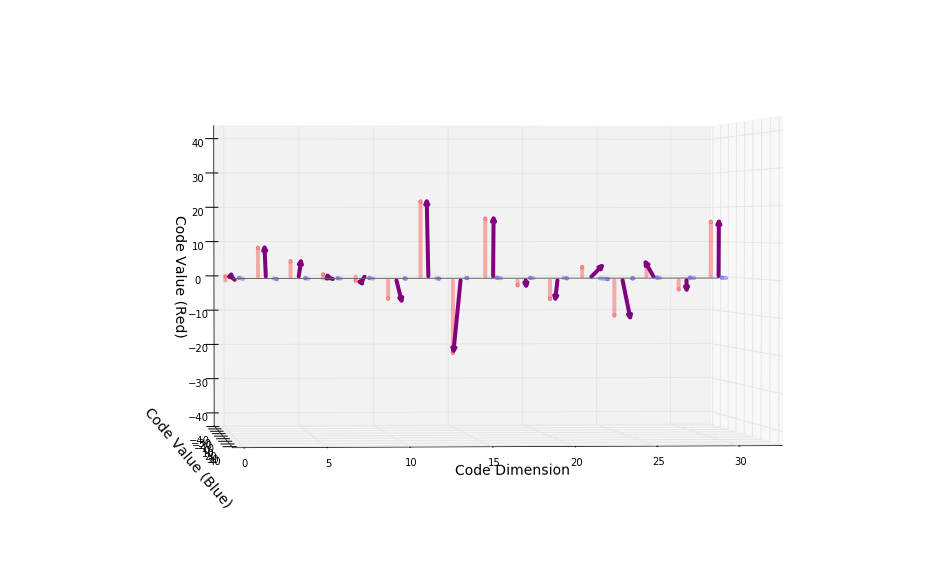

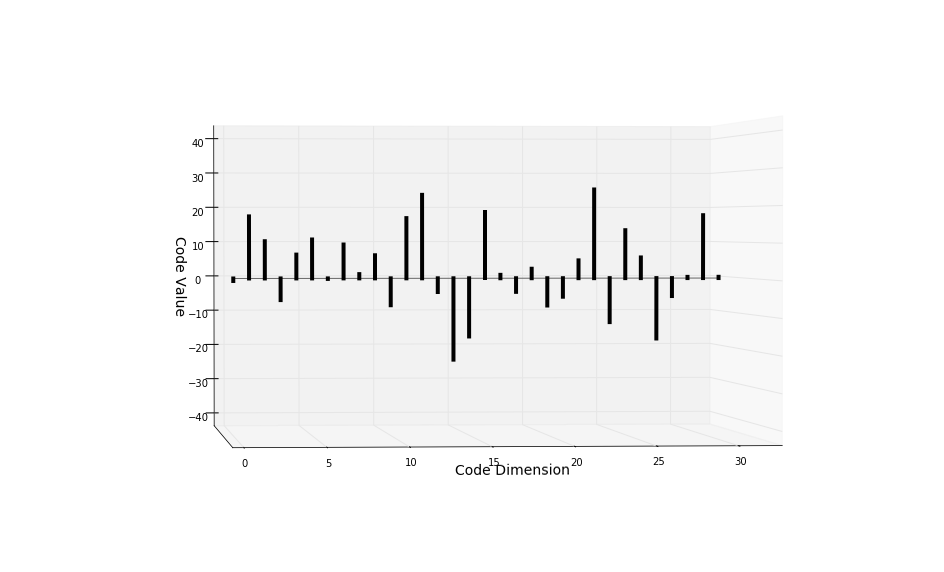

(array([ -0.6902643,  17.21342  ,  10.32905  ,  -6.007096 ,   6.612031 ,
        10.806    ,  -0.142421 ,   9.409728 ,   1.180853 ,   6.416809 ,
        -7.475996 ,  16.74125  ,  23.21222  ,  -3.814054 , -22.65488  ,
       -16.20758  ,  18.43863  ,   0.9475452,  -3.795711 ,   2.640425 ,
        -7.613914 ,  -5.165477 ,   4.966454 ,  24.73369  , -12.27227  ,
        13.37862  ,   5.769588 , -16.87576  ,  -5.01377  ,   0.3344214,
        17.56799  ,   0.3466441]), 24.733689999999999, -22.654879999999999)


In [92]:
inp_num = 36
trg_num = 72

data_i = 0#8
inp_i = 17
trg_i = 31

code_dim = 16
code_len = code_dim*2

def stuff(data_i, inp_i, trg_i):
    trg_i = trg_i % trg_num
    code_inp = np.loadtxt('rotmnist_vis/%04d/codes_inp_%04d.txt' % (data_i, inp_i))
    code_trans = np.loadtxt('rotmnist_vis/%04d/codes_trans_%04d_%04d.txt' % (data_i, inp_i, trg_i))
    image_inp = imload('rotmnist_vis/%04d/input_%04d.png' % (data_i, inp_i))
    image_trans = imload('rotmnist_vis/%04d/image_%04d_%04d.png' % (data_i, inp_i, trg_i))
    return code_inp, code_trans, image_inp, image_trans


def make_fig():
    fig = plt.figure(figsize=plt.figaspect(0.6)*2.5)
    ax = fig.add_subplot(111, projection='3d')
    zywidth = 42.
    ax.view_init(elev=1., azim=85.)
    ax.set_xlim([0,code_len])
    ax.set_ylim([-zywidth,zywidth])
    ax.set_zlim([-zywidth,zywidth])
    ax.plot([0, code_len-1],[0, 0],[0,0], linewidth=1, color=(0.4, 0.4, 0.4))
    #ax.grid(False)

    ax.invert_xaxis()
    #ax.invert_yaxis()
    #ax.invert_zaxis()
    #ax.set_aspect('equal')
    #plt.axis('off')
    return ax

def plot_codes_2col(ax, codes, angle=90, shift=.5, color_scale=(1.0, 1.0)):
    angle = -np.pi*angle/180.
    y_end = np.zeros(code_len)
    z_end = codes
    
    x = np.linspace(0.5-shift, code_len-1-0.5+shift, code_dim)
    y = np.zeros(code_len)
    z = np.zeros(code_len)

    Rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    
    color_num = 4
    cmap=plt.get_cmap('gnuplot', color_num+2)
    colors = [cmap(i)[0:3] for i in range(1,color_num+1)]
    colors[0] = (1.0, 0., 0.)
    colors[1] = (0.0, 0., 1.)
    colors[2] = (0.5, 0., .5)

    ax.set_xlabel('Code Dimension', fontsize=14)
    ax.set_ylabel('Code Value (Blue)', fontsize=14)
    ax.set_zlabel('Code Value (Red)', fontsize=14)

    for i in range(code_dim):
        cur_color = colors[0]
        cur_x = x[i]-shift
        cur_y_end = y_end[2*i]
        cur_z_end = z_end[2*i]
        draw_arrow(ax, [cur_x, cur_x], [0, cur_y_end], [0, cur_z_end], cur_color, alpha=color_scale[0], pointiness=1)

        cur_color = colors[1]
        tmp = np.matmul(Rot, np.vstack([y_end[2*i+1], z_end[2*i+1]]))
        cur_x = x[i]+shift
        cur_y_end = tmp[0]
        cur_z_end = tmp[1]
        draw_arrow(ax, [cur_x, cur_x], [0, cur_y_end], [0, cur_z_end], cur_color, alpha=color_scale[0], pointiness=1)
        
        
        cur_color = colors[2]
        tmp = np.matmul(Rot, np.vstack([y_end[2*i+1], z_end[2*i+1]]))
        cur_x = x[i]
        cur_y_end = tmp[0] + y_end[2*i]
        cur_z_end = tmp[1] + z_end[2*i]
        draw_arrow(ax, [cur_x, cur_x], [0, cur_y_end], [0, cur_z_end], cur_color, alpha=color_scale[1])
    

def plot_codes_sca(ax, codes):
    ax.set_xlabel('Code Dimension', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    ax.set_zlabel('Code Value', fontsize=14)
    ax.set_yticks([])
    
    y_end = np.zeros(code_len)
    z_end = codes
    
    x = np.linspace(0, code_len-1, code_len)
    y = np.zeros(code_len)
    z = np.zeros(code_len)

    for i in range(code_len):
        ax.plot([x[i], x[i]],[y[i], y_end[i]],[z[i], z_end[i]], linewidth=4, color='black')


ax = make_fig()
code_inp,_, image_inp, image_trans = stuff(data_i, inp_i, trg_i)
plot_codes_2col(ax, code_inp, color_scale=(0.3,1.0))
plt.show()
ax = make_fig()
plot_codes_sca(ax, code_inp)
plt.show()
print(code_inp, np.amax(code_inp), np.amin(code_inp))
#plt.savefig(outfile, bbox_inches='tight')

# plt.figure()
# plt.imshow(image_inp)
# plt.show()
# plt.figure()
# plt.imshow(image_trans)
# plt.show()

In [93]:
trg_i = 31
for data_i in [8]:#range(10):
    #print(data_i)
    for inp_i in [17]:#range(inp_num):
        print(inp_i)
        print(data_i, inp_i, trg_i)
        code_inp, code_trans, _, _ = stuff(data_i, inp_i, trg_i)
        print(code_inp)
        print(np.amin(code_inp), np.amax(code_inp))

17
(8, 17, 31)
[ 21.62645   -21.69095   -15.45299    -4.592208    9.926878   -3.856325
 -14.69047     1.347637   -2.840773    8.55841     9.887459   16.66666
  41.84433     0.133776    0.4618931   1.314927   -0.9389363   5.950472
  11.22948     0.7202158  -1.403225  -14.0133     -3.766188    5.127662
   1.832346   -7.594725    2.327473   19.53824   -18.42935   -21.74468
  -6.058916   21.0524   ]
(-21.744679999999999, 41.844329999999999)
